# 序列模型
$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$$

In [41]:
# Import 一大堆玩意
%matplotlib inline
import sys
sys.path.append("../")

from pltutils import *
import torch as t
import torch.nn as nn

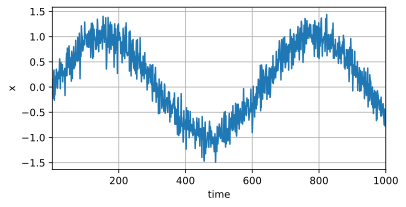

In [42]:
# 生成序列数据

T=1000
times = t.arange(1,T+1,dtype=t.float32)
x=t.sin(0.01*times)+t.normal(0,0.2,(T,))
plot(times,[x],"time","x",xlim=[1,1000],figsize=(6,3))

In [43]:
# 将序列转换成模型的“特征-标签”对
tau =4 
features =t.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:T-tau+i]

labels = x[tau:].reshape((-1,1))

batch_size,n_train=16,600

train_iter = load_array((features[:n_train],labels[:n_train]),batch_size=batch_size,is_train=True)


In [44]:
# 定义模型
def init_weights(m:nn.Module):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net()->nn.Module:
    net =nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1),
    )
    net.apply(init_weights)
    return net



In [45]:
# 定义训练函数
def train(net:nn.Module,train_iter,loss,epochs:int,lr:float):
    trainer=t.optim.Adam(net.parameters(),lr=lr)

    for epoch in range(1,epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f"Epoch-{epoch},loss:{evaluate_loss(net,train_iter,loss):f}")

In [46]:
net =get_net()
loss=nn.MSELoss(reduction='none')
train(net,train_iter,loss,8,0.1)

Epoch-1,loss:0.069030
Epoch-2,loss:0.066535
Epoch-3,loss:0.089535
Epoch-4,loss:0.067247
Epoch-5,loss:0.075782
Epoch-6,loss:0.093554
Epoch-7,loss:0.072906


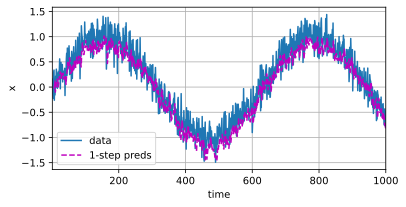

In [47]:
# 预测模型
onestep_preds = net(features)
plot([times, times[tau:]],
     [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
     'x', legend=['data', '1-step preds'], xlim=[1, 1000],
     figsize=(6, 3))


# 可以看到1步预测与结果偏差不大

即使超过了600的时间步，预测的结果仍然是正确的

# $k$步预测

对于直到$x_t$的序列，其在时间步$t+k$处的预测输出$\hat {x}_{t+k}$称为$k$步预测(k-step-ahead-prediction)，我们必须使用我们自己的预测而不是原始数据$x_{t+1}$

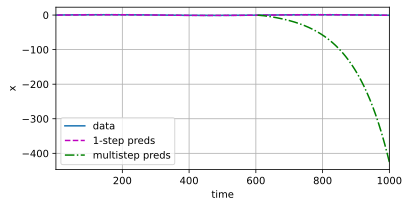

In [48]:
multistep_preds=t.zeros(T)
multistep_preds[:n_train+tau]=x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i]=net(multistep_preds[i-tau:i].reshape((1,-1)))
plot([times, times[tau:], times[n_train + tau:]],
     [x.detach().numpy(), onestep_preds.detach().numpy(),
      multistep_preds[n_train + tau:].detach().numpy()], 'time',
     'x', legend=['data', '1-step preds', 'multistep preds'],
     xlim=[1, 1000], figsize=(6, 3))


In [49]:
# 查看预测的数据
multistep_preds[n_train + tau:]

tensor([  -0.5377,   -0.4730,   -0.4567,   -0.5997,   -0.6681,   -0.6984,
          -0.7567,   -0.8441,   -0.9143,   -0.9815,   -1.0600,   -1.1457,
          -1.2304,   -1.3183,   -1.4125,   -1.5114,   -1.6137,   -1.7210,
          -1.8339,   -1.9477,   -2.0617,   -2.1792,   -2.2998,   -2.4221,
          -2.5465,   -2.6738,   -2.8038,   -2.9361,   -3.0711,   -3.2088,
          -3.3493,   -3.4925,   -3.6361,   -3.7804,   -3.9267,   -4.0745,
          -4.2233,   -4.3735,   -4.5252,   -4.6783,   -4.8327,   -4.9886,
          -5.1459,   -5.3047,   -5.4649,   -5.6266,   -5.7898,   -5.9545,
          -6.1207,   -6.2884,   -6.4577,   -6.6285,   -6.8009,   -6.9749,
          -7.1505,   -7.3277,   -7.5066,   -7.6871,   -7.8692,   -8.0530,
          -8.2386,   -8.4258,   -8.6147,   -8.8054,   -8.9979,   -9.1921,
          -9.3881,   -9.5859,   -9.7855,   -9.9870,  -10.1903,  -10.3955,
         -10.6026,  -10.8115,  -11.0224,  -11.2353,  -11.4501,  -11.6669,
         -11.8857,  -12.1065,  -12.329

经过几个预测步骤之后，结果会收敛到一个常数,这是因为我们的输出是有偏差的，假设第一次的输出有偏差$\epsilon_1=\bar\epsilon$，之后又有$\epsilon_2=\bar\epsilon+c\epsilon_1$,其中$c$为某个常数，后面的预测误差以此类推。

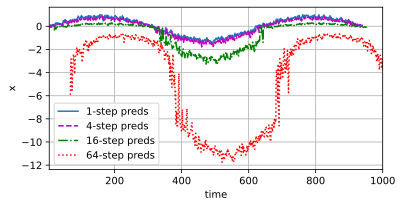

In [50]:
max_steps=64

features=t.zeros(T-tau-max_steps+1,tau+max_steps)

for i in range(tau):
    features[:,i]=x[i:i+T-tau-max_steps+1]

for i in range(tau,tau+max_steps):
    features[:,i]=net(features[:,i-tau:i]).reshape(-1)

steps=[1,4,16,64]

plot([times[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))